In [1]:
import sys
sys.path.append("...")
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from src.config import ACTIVITIES, ABBR, TZ_PARIS, TZ_LONDON
from src.viz_style import apply_nature_style

apply_nature_style()

In [3]:
from src.utils_time import to_local_time_series, split_cross_midnight, week_start_monday
from src.utils_split import split_users_by_hash
from src.regularity import regularity_report, summarize_reg, compute_user_hex_stats, infer_home_work_anchors, make_hex_lookup

In [4]:
from pathlib import Path

ROOT = Path(".")
OUT_DATA = ROOT / "outputs" / "data"
OUT_FIG  = ROOT / "outputs" / "figures"
OUT_FIG.mkdir(parents=True, exist_ok=True)

paris_train = pd.read_parquet(OUT_DATA / "paris_stays_train.parquet")
paris_valid = pd.read_parquet(OUT_DATA / "paris_stays_valid.parquet")

for d in [paris_train, paris_valid]:
    d["user_id"] = d["user_id"].astype(str)
    d["start_time"] = pd.to_datetime(d["start_time"])
    d["end_time"] = pd.to_datetime(d["end_time"])
    d["duration_min"] = pd.to_numeric(d["duration_min"], errors="coerce")
    d["hex_id"] = d["hex_id"].astype(str).replace({"": np.nan, "nan": np.nan})
    d.dropna(subset=["hex_id","start_time","end_time","duration_min","y_true"], inplace=True)

# Huff POI (Paris centers) from notebook 03
poi_path = OUT_DATA / "paris_poi_huff_k4_b1.5.parquet"
poi = pd.read_parquet(poi_path)
poi["hex_id"] = poi["hex_id"].astype(str)

POI_COLS = ["poi_edu_cnt","poi_health_cnt","poi_retail_cnt","poi_leisure_cnt",
            "poi_transport_cnt","poi_accom_cnt","poi_office_cnt","poi_total_cnt"]
for c in POI_COLS:
    if c not in poi.columns:
        poi[c] = 0

poi_lookup = {r.hex_id: r for r in poi[["hex_id"]+POI_COLS].itertuples(index=False)}

print("Paris train stays:", len(paris_train), "users:", paris_train["user_id"].nunique())
print("Paris valid stays:", len(paris_valid), "users:", paris_valid["user_id"].nunique())
print("Paris Huff POI hex:", len(poi_lookup))

Paris train stays: 49803 users: 2482
Paris valid stays: 12437 users: 621
Paris Huff POI hex: 29628


In [5]:
# time bins: minutes from 00:00
TIME_BINS = [(0,360),(360,600),(600,960),(960,1200),(1200,1440)]   # 0-6,6-10,10-16,16-20,20-24
DUR_BINS  = [(0,10),(10,30),(30,120),(120,360),(360,720),(720,1e9)]

def time_bin_id(minute):
    for i,(a,b) in enumerate(TIME_BINS):
        if a <= minute < b: return i
    return -1

def dur_bin_id(dmin):
    for i,(a,b) in enumerate(DUR_BINS):
        if a <= dmin < b: return i
    return -1

act2i = {a:i for i,a in enumerate(ACTIVITIES)}
i2act = {i:a for a,i in act2i.items()}
K = len(ACTIVITIES)

def build_emissions_from_stays(stays_df, alpha=1.0):
    B = len(TIME_BINS)
    D = len(DUR_BINS)
    C_arr = np.zeros((K,B), float)
    C_dur = np.zeros((K,D), float)

    st = stays_df["start_time"]
    arr_min = st.dt.hour*60 + st.dt.minute
    ab = arr_min.apply(lambda m: time_bin_id(int(m)))
    db = stays_df["duration_min"].astype(float).apply(lambda d: dur_bin_id(float(d)))

    for a, abin, dbin in zip(stays_df["y_true"].astype(str), ab, db):
        if abin < 0 or dbin < 0: 
            continue
        i = act2i[a]
        C_arr[i, int(abin)] += 1
        C_dur[i, int(dbin)] += 1

    P_arr = (C_arr + alpha); P_arr = P_arr / P_arr.sum(axis=1, keepdims=True)
    P_dur = (C_dur + alpha); P_dur = P_dur / P_dur.sum(axis=1, keepdims=True)
    return P_arr, P_dur

P_arr, P_dur = build_emissions_from_stays(paris_train, alpha=1.0)
print("P_arr shape:", P_arr.shape, "P_dur shape:", P_dur.shape)

P_arr shape: (7, 5) P_dur shape: (7, 6)


In [11]:
ALPHA_TRANS = 1.0
RHO_SHRINK = 0.3
BREAK_GAP_HOURS = 8

def build_A_dict_from_stays(stays_df, alpha=1.0, rho=0.3, break_gap_hours=8):
    df = stays_df.sort_values(["user_id","start_time"]).copy()

    # helper: context key from a timestamp
    def ctx(dt):
        w = int(dt.weekday() >= 5)
        tb = time_bin_id(int(dt.hour*60 + dt.minute))
        return (w, tb)

    # init counts
    C_global = np.zeros((K,K), float)
    C_bucket = {}  # (w,tb)->counts

    # build transitions within each user, within segments
    for u, g in df.groupby("user_id", sort=False):
        parts = split_by_gap(g, break_gap_hours=break_gap_hours)
        for seq in parts:
            y = seq["y_true"].astype(str).values
            ts = seq["start_time"].values
            for i in range(len(seq)-1):
                a, b = y[i], y[i+1]
                if a not in act2i or b not in act2i:
                    continue
                # use context at time of current stay i
                dt = seq.iloc[i]["start_time"]
                w, tb = ctx(dt)
                if tb < 0:
                    continue

                if (w,tb) not in C_bucket:
                    C_bucket[(w,tb)] = np.zeros((K,K), float)

                ii, jj = act2i[a], act2i[b]
                C_bucket[(w,tb)][ii, jj] += 1.0
                C_global[ii, jj] += 1.0

    def row_norm(C):
        A = C + alpha
        A = A / A.sum(axis=1, keepdims=True)
        return A

    A_global = row_norm(C_global)

    A_dict = {}
    for w in [0,1]:
        for tb in range(len(TIME_BINS)):
            C = C_bucket.get((w,tb))
            if C is None:
                A_dict[(w,tb)] = A_global.copy()
            else:
                A = row_norm(C)
                A = (1-rho)*A + rho*A_global
                A = A / A.sum(axis=1, keepdims=True)
                A_dict[(w,tb)] = A
    return A_dict, A_global

A_dict, A_global = build_A_dict_from_stays(paris_train, alpha=ALPHA_TRANS, rho=RHO_SHRINK, break_gap_hours=BREAK_GAP_HOURS)

def A_getter(seq, t):
    dt = seq.iloc[t]["start_time"]
    w = int(dt.weekday() >= 5)
    tb = time_bin_id(int(dt.hour*60 + dt.minute))
    return A_dict[(w,tb)]

In [12]:
import math

def logsumexp(v):
    m = np.max(v)
    return float(m + np.log(np.sum(np.exp(v - m))))

def viterbi_decode(logB, seq, self_loop_bonus=0.2):
    eps = 1e-12
    T, K0 = logB.shape
    log_pi = np.log(np.full(K0, 1.0/K0))

    dp = np.full((T,K0), -np.inf)
    bp = np.zeros((T,K0), dtype=int)
    dp[0] = log_pi + logB[0]
    bp[0] = -1

    for t in range(1, T):
        A = A_getter(seq, t-1)
        logA = np.log(A + eps)
        for j in range(K0):
            scores = dp[t-1] + logA[:,j] + self_loop_bonus*(np.arange(K0)==j)
            i_star = int(np.argmax(scores))
            bp[t,j] = i_star
            dp[t,j] = scores[i_star] + logB[t,j]

    last = int(np.argmax(dp[T-1]))
    path = [last]
    for t in range(T-1,0,-1):
        last = bp[t,last]
        path.append(last)
    return np.array(path[::-1], dtype=int)

def forward_backward(logB, seq, self_loop_bonus=0.2):
    eps = 1e-12
    T, K0 = logB.shape
    log_pi = np.log(np.full(K0, 1.0/K0))

    log_alpha = np.full((T,K0), -np.inf)
    log_alpha[0] = log_pi + logB[0]

    for t in range(1,T):
        A = A_getter(seq, t-1); logA = np.log(A + eps)
        for j in range(K0):
            tmp = log_alpha[t-1] + logA[:,j] + self_loop_bonus*(np.arange(K0)==j)
            log_alpha[t,j] = logB[t,j] + logsumexp(tmp)

    log_beta = np.full((T,K0), -np.inf)
    log_beta[T-1] = 0.0
    for t in range(T-2,-1,-1):
        A = A_getter(seq, t); logA = np.log(A + eps)
        for i in range(K0):
            tmp = logA[i,:] + self_loop_bonus*(np.arange(K0)==i) + logB[t+1,:] + log_beta[t+1,:]
            log_beta[t,i] = logsumexp(tmp)

    log_gamma = log_alpha + log_beta
    gamma = np.zeros_like(log_gamma)
    for t in range(T):
        z = logsumexp(log_gamma[t])
        gamma[t] = np.exp(log_gamma[t] - z)
    return gamma

In [83]:
# ---- params: start from your Paris best (you can paste your best_params dict here) ----
params = dict(
    W_LOC=0.1,
    W_HOME_ANCHOR=1.8,
    W_WORK_ANCHOR=0.1,

    W_EDU=1.5,
    W_HEALTH=1.2,
    W_RETAIL=0.4,
    W_LEISURE=0.3,
    W_ACCOM=0.10,

    POI_MIN_EDU=1,
    POI_MIN_HEALTH=1,
    POI_MIN_RETAIL=1,
    POI_MIN_LEISURE=1,

    W_OTHER_BASE=0.3,
)


params.update({
    "R_STUDY": 0.15,
    "R_HEALTH": 0.12,
    "R_PURCHASE": 0.30,
    "R_LEISURE": 0.30,
    "P_WEAK_STUDY": 0.15,
    "P_WEAK_HEALTH": 0.10,
    "P_WEAK_PURCHASE": 0.25,
    "P_WEAK_LEISURE": 0.20,
    "W_RATIO": 2.0,
})

LOC_COEF = dict(
    HOME_NIGHT=1.5, HOME_WORK=-1.5,
    WORK_WORK=1.5, WORK_NIGHT=-2.0,
    STUDY_WORK=1.5, STUDY_NIGHT=-2.0,
    OTHER_BASE=-0.9
)

def loc_score_param(u, h, act, hex_lookup, p=LOC_COEF):
    st = hex_lookup.get((u, str(h)), None)
    if st is None:
        return 0.0
    base = np.log1p(st.visit_days)
    if act == "HOME":
        return base + p["HOME_NIGHT"]*st.night_share + p["HOME_WORK"]*st.work_share
    if act == "WORK":
        return base + p["WORK_WORK"]*st.work_share + p["WORK_NIGHT"]*st.night_share
    if act == "STUDY":
        return base + p["STUDY_WORK"]*st.work_share + p["STUDY_NIGHT"]*st.night_share
    return p["OTHER_BASE"]*base

# anchors from Paris valid (use only valid set for evaluation; in practice you'd compute per dataset)
hs_valid = compute_user_hex_stats(paris_valid)
anchors_valid = infer_home_work_anchors(hs_valid)
home_lookup = dict(zip(anchors_valid["user_id"], anchors_valid["home_hex"]))
work_lookup = dict(zip(anchors_valid["user_id"], anchors_valid["work_hex"]))
hex_lookup = make_hex_lookup(hs_valid)

def anchor_bonus(u, h, act, home_lookup, work_lookup, w_home, w_work):
    h0 = str(h)
    if act == "HOME" and home_lookup.get(u) is not None and h0 == str(home_lookup[u]):
        return w_home
    if act == "WORK" and work_lookup.get(u) is not None and h0 == str(work_lookup[u]):
        return w_work
    return 0.0

def get_poi_counts(h):
    r = poi_lookup.get(str(h), None)
    if r is None:
        return 0,0,0,0,0
    return (int(getattr(r, "poi_edu_cnt", 0) or 0),
            int(getattr(r, "poi_health_cnt", 0) or 0),
            int(getattr(r, "poi_retail_cnt", 0) or 0),
            int(getattr(r, "poi_leisure_cnt", 0) or 0),
            int(getattr(r, "poi_accom_cnt", 0) or 0))


# ---- add these to params (recommended starting values for Huff POI) ----
# params.update({
#   "R_STUDY": 0.20, "R_HEALTH": 0.18, "R_PURCHASE": 0.30, "R_LEISURE": 0.30,
#   "P_WEAK_STUDY": 0.30, "P_WEAK_HEALTH": 0.20, "P_WEAK_PURCHASE": 0.10, "P_WEAK_LEISURE": 0.10,
#   "W_RATIO": 2.0,   # how strongly ratio contributes when gated-in
# })
# If you want no negative penalty for PURCHASE/LEISURE, set P_WEAK_PURCHASE=P_WEAK_LEISURE=0.0

def poi_term_semantic(act, edu, health, retail, leisure, accom, params):
    """
    Unified semantic POI scoring for: STUDY/HEALTH/PURCHASE/LEISURE
    Score = + W * (log1p(cnt) + W_RATIO * ratio)  if (cnt>=min_cnt AND ratio>=ratio_th)
            - P_WEAK_act                          otherwise (soft constraint)
    """
    sem = edu + health + retail + leisure
    # avoid division by zero; +1 keeps ratios defined even when sem=0
    denom = sem + 1.0

    if act == "STUDY":
        cnt = float(edu)
        ratio = cnt / denom
        min_cnt = int(params.get("POI_MIN_EDU", 1))
        ratio_th = float(params.get("R_STUDY", 0.20))
        w = float(params.get("W_EDU", 0.0))
        pweak = float(params.get("P_WEAK_STUDY", 0.0))

    elif act == "HEALTH":
        cnt = float(health)
        ratio = cnt / denom
        min_cnt = int(params.get("POI_MIN_HEALTH", 1))
        ratio_th = float(params.get("R_HEALTH", 0.18))
        w = float(params.get("W_HEALTH", 0.0))
        pweak = float(params.get("P_WEAK_HEALTH", 0.0))

    elif act == "PURCHASE":
        cnt = float(retail)
        ratio = cnt / denom
        min_cnt = int(params.get("POI_MIN_RETAIL", 1))
        ratio_th = float(params.get("R_PURCHASE", 0.30))
        w = float(params.get("W_RETAIL", 0.0))
        pweak = float(params.get("P_WEAK_PURCHASE", 0.0))

    elif act == "LEISURE":
        cnt = float(leisure)
        ratio = cnt / denom
        min_cnt = int(params.get("POI_MIN_LEISURE", 1))
        ratio_th = float(params.get("R_LEISURE", 0.30))
        w = float(params.get("W_LEISURE", 0.0))
        pweak = float(params.get("P_WEAK_LEISURE", 0.0))

    else:
        return 0.0

    w_ratio = float(params.get("W_RATIO", 2.0))

    # gate-in
    if cnt >= min_cnt and ratio >= ratio_th:
        return w * (np.log1p(cnt) + w_ratio * ratio)

    # soft penalty (single place; no extra penalties elsewhere)
    return -pweak

def other_bonus(u, h, edu, health, retail, leisure):
    st = hex_lookup.get((u, str(h)))
    visit_days = st.visit_days if st is not None else 0
    reg = np.log1p(visit_days)

    sem = edu + health + retail + leisure
    if sem <= 0:
        sem = 0.0
    # dominance: how “peaked” the semantic composition is
    max_ratio = max(edu, health, retail, leisure) / (sem + 1.0)

    # trigger OTHER when (i) low regularity AND (ii) semantic signal is weak or diffuse
    if reg <= np.log1p(1) and (sem < 5 or max_ratio < 0.35):
        return params["W_OTHER_BASE"]
    return 0.0

def build_logB_time_dur(seq):
    T = len(seq)
    logB = np.zeros((T, K), float)
    for t in range(T):
        st = seq.iloc[t]["start_time"]
        dur = float(seq.iloc[t]["duration_min"])
        abin = time_bin_id(int(st.hour*60 + st.minute))
        dbin = dur_bin_id(dur)
        for k in range(K):
            if abin >= 0:
                logB[t,k] += np.log(P_arr[k, abin] + 1e-12)
            if dbin >= 0:
                logB[t,k] += np.log(P_dur[k, dbin] + 1e-12)
    return logB

def split_by_gap(df_u, break_gap_hours=8):
    thr = break_gap_hours * 3600.0
    g = df_u.sort_values("start_time")
    if len(g)==0: return []
    idxs = list(g.index)
    parts=[]; cur=[idxs[0]]
    for a,b in zip(idxs[:-1], idxs[1:]):
        gap = (g.loc[b,"start_time"] - g.loc[a,"end_time"]).total_seconds()
        if gap > thr:
            parts.append(g.loc[cur].copy()); cur=[b]
        else:
            cur.append(b)
    parts.append(g.loc[cur].copy())
    return parts

def decode_hmm_stage3(stays_df, self_loop_bonus=0.2):
    out = stays_df.sort_values(["user_id","start_time"]).copy()
    out["y_pred"] = None
    out["conf"] = np.nan
    out["margin"] = np.nan

    for u, g in out.groupby("user_id", sort=False):
        parts = split_by_gap(g)
        for seq in parts:
            logB = build_logB_time_dur(seq)

            # Stage3 terms
            for t in range(len(seq)):
                h = seq.iloc[t]["hex_id"]
                edu, health, retail, leisure, accom = get_poi_counts(h)

                for k in range(K):
                    act = i2act[k]
                    logB[t, k] += anchor_bonus(u, h, act, home_lookup, work_lookup,
                                              params["W_HOME_ANCHOR"], params["W_WORK_ANCHOR"])
                    logB[t, k] += poi_term_semantic(act, edu, health, retail, leisure, accom, params)
                    
                    # # distance term for HOME/WORK (soft anchor)
                    # if act in ["HOME", "WORK"]:
                    #     lat, lon = centroids.get(str(h), (np.nan, np.nan))
                    #     if np.isfinite(lat):
                    #         D0 = float(params.get("D0_KM", 1.0))
                    #         if act == "HOME":
                    #             hlat, hlon = home_ll.get(u, (np.nan, np.nan))
                    #             if np.isfinite(hlat):
                    #                 dkm = haversine_km(lat, lon, hlat, hlon)
                    #                 logB[t,k] += float(params.get("W_DHOME", 0.0)) * (-(dkm / D0))
                    #         if act == "WORK":
                    #             wlat, wlon = work_ll.get(u, (np.nan, np.nan))
                    #             if np.isfinite(wlat):
                    #                 dkm = haversine_km(lat, lon, wlat, wlon)
                    #                 logB[t,k] += float(params.get("W_DWORK", 0.0)) * (-(dkm / D0))
                    
                    if params["W_LOC"] != 0.0:
                        logB[t,k] += params["W_LOC"] * loc_score_param(u, h, act, hex_lookup)

            path = viterbi_decode(logB, seq, self_loop_bonus=self_loop_bonus)
            gamma = forward_backward(logB, seq, self_loop_bonus=self_loop_bonus)

            out.loc[seq.index, "y_pred"] = [i2act[int(i)] for i in path]

            # conf/margin
            idx_sorted = np.argsort(-gamma, axis=1)
            top1 = idx_sorted[:,0]; top2 = idx_sorted[:,1]
            p1 = gamma[np.arange(len(seq)), top1]
            p2 = gamma[np.arange(len(seq)), top2]
            out.loc[seq.index, "conf"] = p1
            out.loc[seq.index, "margin"] = (p1 - p2)

    return out

HMM (Paris valid, Huff POI) ACC: 0.5411272814987537
HMM Macro: 0.3744386028310081
HMM Macro excl HOME: 0.3074489138020707
              precision    recall  f1-score   support

        HOME      0.834     0.726     0.776      4153
        WORK      0.674     0.606     0.638      2566
       STUDY      0.118     0.177     0.141       237
    PURCHASE      0.375     0.697     0.488      1832
     LEISURE      0.274     0.499     0.354      1290
      HEALTH      0.194     0.043     0.071       301
       OTHER      0.546     0.089     0.153      2058

    accuracy                          0.541     12437
   macro avg      0.431     0.405     0.374     12437
weighted avg      0.598     0.541     0.529     12437

Saved: /Users/pang/Codes/GISRUK/outputs/data/cm_hmm_paris_huff_row_norm.csv


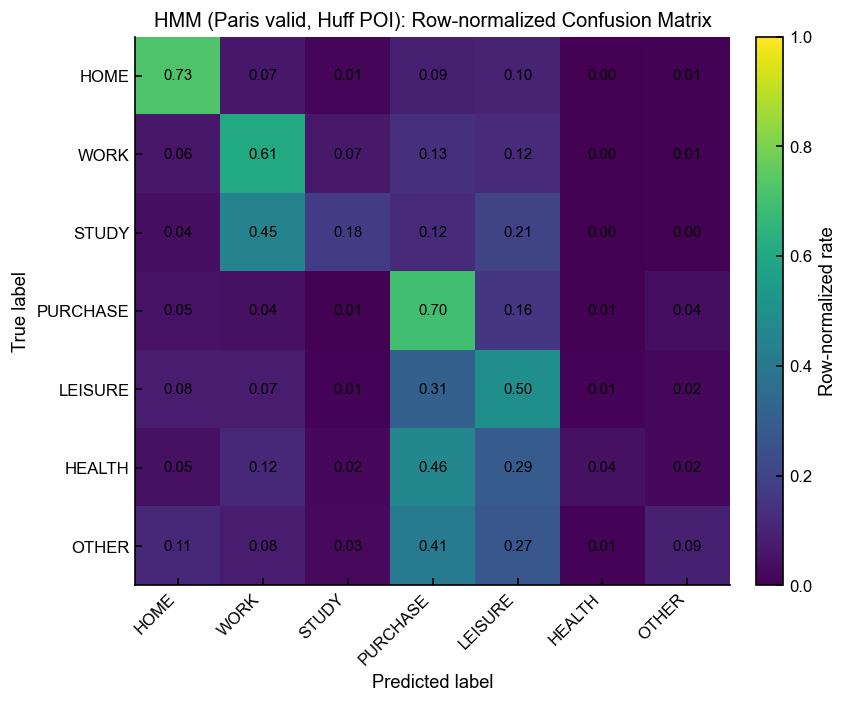

Saved: /Users/pang/Codes/GISRUK/outputs/figures/paris_hmm_huff_row_norm_cm.png


In [84]:
pred_hmm = decode_hmm_stage3(paris_valid, self_loop_bonus=0.2)

from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

y_true = pred_hmm["y_true"].astype(str).values
y_pred = pred_hmm["y_pred"].astype(str).values

acc = accuracy_score(y_true, y_pred)
macro = f1_score(y_true, y_pred, average="macro", labels=ACTIVITIES)
macro_weak = f1_score(y_true, y_pred, average="macro", labels=["WORK","STUDY","PURCHASE","LEISURE","HEALTH","OTHER"])

print("HMM (Paris valid, Huff POI) ACC:", acc)
print("HMM Macro:", macro)
print("HMM Macro excl HOME:", macro_weak)
print(classification_report(y_true, y_pred, labels=ACTIVITIES, digits=3, zero_division=0))

cm = confusion_matrix(y_true, y_pred, labels=ACTIVITIES)
cmn = cm / np.maximum(cm.sum(axis=1, keepdims=True), 1)

cm_csv = OUT_DATA / "cm_hmm_paris_huff_row_norm.csv"
np.savetxt(cm_csv, cmn, delimiter=",", fmt="%.6f")
print("Saved:", cm_csv)

# plot (local helper, same as notebook 05)
apply_nature_style()
def plot_row_norm_cm_local(y_true, y_pred, labels, outpath, title, annotate=True):
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    cmn = cm / np.maximum(cm.sum(axis=1, keepdims=True), 1)
    fig, ax = plt.subplots(figsize=(7.2, 6.0))
    im = ax.imshow(cmn, vmin=0.0, vmax=1.0, aspect="auto")
    cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.ax.tick_params(direction="in")
    cbar.set_label("Row-normalized rate", rotation=90)
    ax.set_title(title)
    ax.set_xlabel("Predicted label")
    ax.set_ylabel("True label")
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels(labels, rotation=45, ha="right")
    ax.set_yticklabels(labels)
    ax.tick_params(direction="in")
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    if annotate:
        for i in range(len(labels)):
            for j in range(len(labels)):
                ax.text(j, i, f"{cmn[i,j]:.2f}", ha="center", va="center", fontsize=9)
    plt.tight_layout()
    fig.savefig(outpath, dpi=300, bbox_inches="tight")
    plt.show()
    plt.close(fig)
    return cmn

cm_png = OUT_FIG / "paris_hmm_huff_row_norm_cm.png"
plot_row_norm_cm_local(y_true, y_pred, ACTIVITIES, str(cm_png),
                       "HMM (Paris valid, Huff POI): Row-normalized Confusion Matrix",
                       annotate=True)
print("Saved:", cm_png)

In [64]:
from sklearn.metrics import confusion_matrix
import pandas as pd
import numpy as np

cm = confusion_matrix(y_true, y_pred, labels=ACTIVITIES)
cm_row = cm / np.maximum(cm.sum(axis=1, keepdims=True), 1)
cm_row_df = pd.DataFrame(cm_row, index=[f"true_{x}" for x in ACTIVITIES],
                         columns=[f"pred_{x}" for x in ACTIVITIES])

print("True WORK row (top):")
print(cm_row_df.loc["true_WORK"].sort_values(ascending=False).head(5))
print("\nTrue HOME row (top):")
print(cm_row_df.loc["true_HOME"].sort_values(ascending=False).head(5))

True WORK row (top):
pred_WORK        0.605612
pred_PURCHASE    0.134451
pred_LEISURE     0.122369
pred_STUDY       0.068589
pred_HOME        0.060795
Name: true_WORK, dtype: float64

True HOME row (top):
pred_HOME        0.726463
pred_LEISURE     0.097038
pred_PURCHASE    0.089574
pred_WORK        0.065254
pred_STUDY       0.012762
Name: true_HOME, dtype: float64


In [70]:
import json
from sklearn.metrics import f1_score, accuracy_score, classification_report, confusion_matrix

OUT_MODELS = Path("/Users/pang/Codes/GISRUK/outputs/models")
OUT_MODELS.mkdir(parents=True, exist_ok=True)
OUT_DATA = Path("/Users/pang/Codes/GISRUK/outputs/data")
OUT_FIG  = Path("/Users/pang/Codes/GISRUK/outputs/figures")
OUT_DATA.mkdir(parents=True, exist_ok=True)
OUT_FIG.mkdir(parents=True, exist_ok=True)


def generate_candidates(center, step, n=5, lo=None, hi=None):
    """Symmetric candidates around center with given step."""
    k = n//2
    vals = [center + step*i for i in range(-k, k+1)]
    if lo is not None: vals = [max(lo, v) for v in vals]
    if hi is not None: vals = [min(hi, v) for v in vals]
    # unique & sorted
    vals = sorted(set([round(v, 6) for v in vals]))
    return vals

def adaptive_candidates(center, step, lo, hi,
                        n=5, max_expand_rounds=3, expand_factor=1.0):
    """
    Start with n candidates around center.
    If best hits boundary, caller can ask for extended range by increasing center or step.
    This function just returns initial candidates; the boundary-expansion loop lives in tuner.
    """
    return generate_candidates(center, step, n=n, lo=lo, hi=hi)

bounds = {
  "W_LOC": (0.0, 0.5),
  "W_HOME_ANCHOR": (0.5, 3.5),
  "W_WORK_ANCHOR": (0.0, 1.0),

  "W_EDU": (0.2, 1.8),
  "W_HEALTH": (0.2, 1.5),
  "W_RETAIL": (0.05, 0.8),
  "W_LEISURE": (0.05, 0.8),

  "R_STUDY": (0.05, 0.5),
  "R_HEALTH": (0.05, 0.5),
  "R_PURCHASE": (0.10, 0.6),
  "R_LEISURE": (0.10, 0.6),

  "P_WEAK_STUDY": (0.0, 1.0),
  "P_WEAK_HEALTH": (0.0, 1.0),
  "P_WEAK_PURCHASE": (0.0, 0.5),
  "P_WEAK_LEISURE": (0.0, 0.5),

  "W_RATIO": (0.5, 5.0),
  "W_OTHER_BASE": (0.0, 1.0),
}

step_map = {
  "W_LOC": 0.05,
  "W_HOME_ANCHOR": 0.2,
  "W_WORK_ANCHOR": 0.1,

  "W_EDU": 0.1,
  "W_HEALTH": 0.1,
  "W_RETAIL": 0.05,
  "W_LEISURE": 0.05,

  "R_STUDY": 0.03,
  "R_HEALTH": 0.03,
  "R_PURCHASE": 0.03,
  "R_LEISURE": 0.03,

  "P_WEAK_STUDY": 0.15,
  "P_WEAK_HEALTH": 0.15,
  "P_WEAK_PURCHASE": 0.05,
  "P_WEAK_LEISURE": 0.05,

  "W_RATIO": 0.5,
  "W_OTHER_BASE": 0.1,
}

In [72]:
WEAK_LABELS = ["WORK","STUDY","PURCHASE","LEISURE","HEALTH","OTHER"]

def eval_pred(df_pred):
    y_true = df_pred["y_true"].astype(str).values
    y_pred = df_pred["y_pred"].astype(str).values
    acc = accuracy_score(y_true, y_pred)
    macro = f1_score(y_true, y_pred, average="macro", labels=ACTIVITIES)
    macro_weak = f1_score(y_true, y_pred, average="macro", labels=WEAK_LABELS)
    return acc, macro, macro_weak

def run_one(params):
    pred = decode_hmm_stage3(paris_valid, self_loop_bonus=0.2)  # uses global params dict inside
    # IMPORTANT: make sure decode_hmm_stage3 reads `params` from outer scope or pass params in explicitly.
    acc, macro, macro_weak = eval_pred(pred)
    return pred, acc, macro, macro_weak


# cache: params_key -> (pred, acc, macro, macro_weak)
_eval_cache = {}

def _key_from_params(p, keys=None):
    # only cache on keys being tuned + the fixed params that affect decode
    # simplest: cache on full dict (safe, a bit larger key)
    items = []
    for k in sorted(p.keys()):
        v = p[k]
        if isinstance(v, (np.floating, np.integer)):
            v = float(v)
        items.append((k, round(float(v), 6)) if isinstance(v, (int,float)) else (k, str(v)))
    return tuple(items)

def run_one_cached(trial):
    k = _key_from_params(trial)
    if k in _eval_cache:
        return _eval_cache[k]
    pred, acc, macro, macro_weak = run_one(trial)
    _eval_cache[k] = (pred, acc, macro, macro_weak)
    return pred, acc, macro, macro_weak

def infer_step(cand_list):
    vals = sorted(set([float(x) for x in cand_list]))
    if len(vals) < 2:
        return 0.1
    diffs = [vals[i+1]-vals[i] for i in range(len(vals)-1)]
    # robust step
    return float(np.median(diffs))

def make_window(center, step, n=5):
    # n must be odd
    k = n//2
    return [round(center + step*i, 6) for i in range(-k, k+1)]

def unique_sorted(vals):
    return sorted(set([round(float(v), 6) for v in vals]))

In [73]:
import time
import copy

def coord_descent_grid_search(params_init, grid, rounds=2):
    global params  # so decode_hmm_stage3 uses updated params
    best_params = copy.deepcopy(params_init)

    # baseline eval
    params = best_params
    pred_best, acc_best, macro_best, macro_weak_best = run_one(best_params)
    print(f"Initial: macro_weak={macro_weak_best:.6f} acc={acc_best:.4f} macro={macro_best:.4f}")

    for r in range(1, rounds+1):
        print(f"\n===== Round {r}/{rounds} =====")
        for pname, cand_list in grid.items():
            local_best_val = best_params[pname]
            local_best_score = macro_weak_best

            t0 = time.time()

            # base candidates you provided (>=5)
            cand0 = list(cand_list)
            step = infer_step(cand0)
            n0 = max(5, len(cand0)) if len(cand0) % 2 == 1 else max(5, len(cand0) + 1)  # keep odd
            cand = unique_sorted(cand0)

            best_val = best_params[pname]
            best_score_local = macro_weak_best
            best_pred_local = None
            best_acc_local = None
            best_macro_local = None

            def eval_at(v):
                trial = copy.deepcopy(best_params)
                trial[pname] = v
                # update global for decoder (as you do)
                global params
                params = trial
                pred, acc, macro, macro_weak = run_one_cached(trial)
                return trial, pred, acc, macro, macro_weak

            # --- 1) initial sweep on provided cand_list ---
            for i, v in enumerate(cand, 1):
                trial, pred, acc, macro, macro_weak = eval_at(v)
                print(f"[{pname}] init {i}/{len(cand)} v={v} -> macro_weak={macro_weak:.6f}", end="\r")

                if macro_weak > best_score_local:
                    best_score_local = macro_weak
                    best_val = v
                    best_pred_local, best_acc_local, best_macro_local = pred, acc, macro

                if macro_weak > macro_weak_best:
                    macro_weak_best = macro_weak
                    acc_best, macro_best = acc, macro
                    best_params = trial
                    pred_best = pred
                    print(f"\n✅ New best: macro_weak={macro_weak_best:.6f} ({pname}={v})")

            # --- 2) boundary expansion: if best hits edge, slide/extend window and re-scan ---
            max_expand_rounds = 3
            for er in range(max_expand_rounds):
                hit_left = (best_val == cand[0])
                hit_right = (best_val == cand[-1])
                if not (hit_left or hit_right):
                    break

                # expand by shifting center outward by half-window
                half = (len(cand)//2)
                shift = step * half

                if hit_left:
                    new_center = best_val - shift
                else:
                    new_center = best_val + shift

                cand = unique_sorted(make_window(new_center, step, n=n0))

                for i, v in enumerate(cand, 1):
                    trial, pred, acc, macro, macro_weak = eval_at(v)
                    print(f"[{pname}] expand{er+1} {i}/{len(cand)} v={v} -> macro_weak={macro_weak:.6f}", end="\r")

                    if macro_weak > best_score_local:
                        best_score_local = macro_weak
                        best_val = v
                        best_pred_local, best_acc_local, best_macro_local = pred, acc, macro

                    if macro_weak > macro_weak_best:
                        macro_weak_best = macro_weak
                        acc_best, macro_best = acc, macro
                        best_params = trial
                        pred_best = pred
                        print(f"\n✅ New best: macro_weak={macro_weak_best:.6f} ({pname}={v})")

            # --- 3) local refinement around best_val (finer step) ---
            fine_step = step / 2.0
            cand_fine = unique_sorted(make_window(best_val, fine_step, n=7))

            for i, v in enumerate(cand_fine, 1):
                trial, pred, acc, macro, macro_weak = eval_at(v)
                print(f"[{pname}] refine {i}/{len(cand_fine)} v={v} -> macro_weak={macro_weak:.6f}", end="\r")

                if macro_weak > best_score_local:
                    best_score_local = macro_weak
                    best_val = v
                    best_pred_local, best_acc_local, best_macro_local = pred, acc, macro

                if macro_weak > macro_weak_best:
                    macro_weak_best = macro_weak
                    acc_best, macro_best = acc, macro
                    best_params = trial
                    pred_best = pred
                    print(f"\n✅ New best: macro_weak={macro_weak_best:.6f} ({pname}={v})")

            # commit local best
            best_params[pname] = best_val
            print(f"\n{pname} best: {best_val} | macro_weak={best_score_local:.6f} | time={time.time()-t0:.1f}s")

    return best_params, pred_best, acc_best, macro_best, macro_weak_best

In [74]:
best_params_grid, pred_best, acc_best, macro_best, macro_weak_best = coord_descent_grid_search(params, GRID, rounds=2)

print("\n===== Search finished =====")
print("Best macro_weak:", macro_weak_best)
print("Best acc/macro:", acc_best, macro_best)
print("Best params:", best_params_grid)

# save best params
param_path = OUT_MODELS / "paris_hmm_huff_best_params_grid.json"
with open(param_path, "w") as f:
    json.dump(best_params_grid, f, indent=2)
print("Saved:", param_path)

# save row-normalized CM
y_true = pred_best["y_true"].astype(str).values
y_pred = pred_best["y_pred"].astype(str).values
cm = confusion_matrix(y_true, y_pred, labels=ACTIVITIES)
cmn = cm / np.maximum(cm.sum(axis=1, keepdims=True), 1)
cm_csv = OUT_DATA / "cm_hmm_paris_huff_grid_row_norm.csv"
np.savetxt(cm_csv, cmn, delimiter=",", fmt="%.6f")
print("Saved:", cm_csv)

Initial: macro_weak=0.341677 acc=0.5791 macro=0.4057

===== Round 1/2 =====
[W_LOC] init 1/7 v=0.0 -> macro_weak=0.344679
✅ New best: macro_weak=0.344679 (W_LOC=0.0)
[W_LOC] init 3/7 v=0.1 -> macro_weak=0.3454981
✅ New best: macro_weak=0.345498 (W_LOC=0.1)
[W_LOC] refine 5/7 v=0.125 -> macro_weak=0.346323
✅ New best: macro_weak=0.346323 (W_LOC=0.125)
[W_LOC] refine 7/7 v=0.175 -> macro_weak=0.344453
W_LOC best: 0.125 | macro_weak=0.346323 | time=89.2s
[W_HOME_ANCHOR] init 1/5 v=1.0 -> macro_weak=0.346385
✅ New best: macro_weak=0.346385 (W_HOME_ANCHOR=1.0)
[W_HOME_ANCHOR] init 3/5 v=1.8 -> macro_weak=0.346744
✅ New best: macro_weak=0.346744 (W_HOME_ANCHOR=1.8)
[W_HOME_ANCHOR] refine 5/7 v=2.0 -> macro_weak=0.346755
✅ New best: macro_weak=0.346755 (W_HOME_ANCHOR=2.0)
[W_HOME_ANCHOR] refine 7/7 v=2.4 -> macro_weak=0.346529
W_HOME_ANCHOR best: 2.0 | macro_weak=0.346755 | time=65.1s
[W_WORK_ANCHOR] init 4/5 v=0.15 -> macro_weak=0.347112
✅ New best: macro_weak=0.347112 (W_WORK_ANCHOR=0.15)
[

In [85]:
from pathlib import Path
OUT_DATA = Path("/Users/pang/Codes/GISRUK/outputs/data")
OUT_DATA.mkdir(parents=True, exist_ok=True)

df = pred_best.copy()  # or your final best pred dataframe
df = df.rename(columns={"y_pred":"y_pred"})  # already
df[["user_id","start_time","end_time","hex_id","duration_min","y_true","y_pred"]].to_parquet(
    OUT_DATA / "paris_valid_pred_hmm.parquet",
    index=False
)
print("Saved:", OUT_DATA / "paris_valid_pred_hmm.parquet")

Saved: /Users/pang/Codes/GISRUK/outputs/data/paris_valid_pred_hmm.parquet


In [78]:
import math, h3

def cell_to_latlon(cell):
    if hasattr(h3, "cell_to_latlng"):
        lat, lon = h3.cell_to_latlng(cell)
    else:
        lat, lon = h3.h3_to_geo(cell)
    return float(lat), float(lon)

def haversine_km(lat1, lon1, lat2, lon2):
    R = 6371.0
    p1, p2 = math.radians(lat1), math.radians(lat2)
    dphi = math.radians(lat2-lat1)
    dlmb = math.radians(lon2-lon1)
    a = math.sin(dphi/2)**2 + math.cos(p1)*math.cos(p2)*math.sin(dlmb/2)**2
    return 2*R*math.asin(math.sqrt(a))

In [79]:
# centroids for all hex that appear in stays (valid is enough for evaluation)
all_hex = pd.Index(paris_valid["hex_id"].astype(str).unique())
centroids = {h: cell_to_latlon(h) for h in all_hex}

def anchor_latlon(u, anchor_lookup):
    hh = anchor_lookup.get(u, None)
    if hh is None or str(hh) not in centroids:
        return (np.nan, np.nan)
    return centroids[str(hh)]

home_ll = {u: anchor_latlon(u, home_lookup) for u in home_lookup.keys()}
work_ll = {u: anchor_latlon(u, work_lookup) for u in work_lookup.keys()}

In [80]:
params["W_DHOME"] = 1.0     # strength of home distance term
params["W_DWORK"] = 1.0     # strength of work distance term
params["D0_KM"] = 1.0       # distance scale in km